In [ ]:
!nvidia-smi

Fri Mar  4 15:50:17 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  A100-SXM4-40GB      Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    41W / 400W |      0MiB / 40536MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!git clone https://github.com/google-research/long-range-arena.git

Cloning into 'long-range-arena'...
remote: Enumerating objects: 474, done.
remote: Counting objects: 100% (474/474), done.
remote: Compressing objects: 100% (195/195), done.
remote: Total 474 (delta 330), reused 418 (delta 278), pack-reused 0
Receiving objects: 100% (474/474), 153.25 KiB | 6.66 MiB/s, done.
Resolving deltas: 100% (330/330), done.


In [ ]:
#Execute if A100 is the current GPU

!pip3 install torch==1.10.0+cu113 torchvision==0.11.1+cu113 torchaudio==0.10.0+cu113 -f https://download.pytorch.org/whl/cu113/torch_stable.html

Looking in links: https://download.pytorch.org/whl/cu113/torch_stable.html
     |██████████████▋                 | 834.1 MB 1.2 MB/s eta 0:13:44tcmalloc: large alloc 1147494400 bytes == 0x55af85ab8000 @  0x7fedb82ef615 0x55af837403bc 0x55af8382118a 0x55af837431cd 0x55af83835b3d 0x55af837b7458 0x55af837b202f 0x55af83744aba 0x55af837b72c0 0x55af837b202f 0x55af83744aba 0x55af837b3cd4 0x55af83836986 0x55af837b3350 0x55af83836986 0x55af837b3350 0x55af83836986 0x55af837b3350 0x55af83744f19 0x55af83788a79 0x55af83743b32 0x55af837b71dd 0x55af837b202f 0x55af83744aba 0x55af837b3cd4 0x55af837b202f 0x55af83744aba 0x55af837b2eae 0x55af837449da 0x55af837b3108 0x55af837b202f
     |██████████████████▌             | 1055.7 MB 1.2 MB/s eta 0:10:30tcmalloc: large alloc 1434370048 bytes == 0x55afca10e000 @  0x7fedb82ef615 0x55af837403bc 0x55af8382118a 0x55af837431cd 0x55af83835b3d 0x55af837b7458 0x55af837b202f 0x55af83744aba 0x55af837b72c0 0x55af837b202f 0x55af83744aba 0x55af837b3cd4 0x55af83836986 0x55af

In [ ]:
%cd /content/long-range-arena

import torch
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

from lra_benchmarks.text_classification.input_pipeline import get_tc_datasets

batch_size=8
accumulation_steps=32 // batch_size
max_length=4000

train_dataset, valid_dataset, test_dataset, encoder = get_tc_datasets(1, 'imdb_reviews', batch_size=batch_size, max_length=max_length)

/content/long-range-arena


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8PVXSW/imdb_reviews-train.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8PVXSW/imdb_reviews-test.tfrecord


  0%|          | 0/25000 [00:00<?, ? examples/s]

0 examples [00:00, ? examples/s]

Shuffling and writing examples to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0.incomplete8PVXSW/imdb_reviews-unsupervised.tfrecord


  0%|          | 0/50000 [00:00<?, ? examples/s]

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.
INFO:tensorflow:Finished preprocessing


INFO:tensorflow:Finished preprocessing


INFO:tensorflow:<MapDataset element_spec={'Source': TensorSpec(shape=(), dtype=tf.string, name=None), 'Target': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


INFO:tensorflow:<MapDataset element_spec={'Source': TensorSpec(shape=(), dtype=tf.string, name=None), 'Target': TensorSpec(shape=(), dtype=tf.int64, name=None)}>


In [ ]:
sample = next(iter(train_dataset))['inputs']

for i in range(min(4, batch_size)):
  print(encoder.decode(sample[i]))

Back in the day, I remembered seeing dumb Nintendo Power comics that had the same artwork as this show... and then word came up that this show was a coming to a television near me! I was not estatic, but curious... I was curious about how bad this show was gonna suck. My friends all said that this show had no real meanings and was too silly for straight people like me to enjoy (i'm actually gay), so I decided to watch the show with low expectations.<br /><br />WHAT A HORRIBLE EXPERIENCE!!!!!!!!!!! First off, I hate the new characters. Tiff and Tuff are so dumb and I hate how so many fanboys drool over Tiff, it's sad. I also hate how they made Chef Kalasaki (or whatever his nonstraight name was) a good guy who owned a restaurant. Bad move, 4Kids TV! Escargoon is nothing but a loser adviser to the King Dedede (who sucks big time in this show) and I hate the face of that one company that keeps supplying Dedede with those awful weapons to destroy Kirby. So stupid, I hate this show.<br /><b

In [ ]:
import torch.nn as nn
import math

LAMBDA = 0.1

class TEmbedding(nn.Module):
  def __init__(self, num_embeddings, hidden_dim, seq_length=1024, padding_idx=0):
    super(TEmbedding, self).__init__()
    
    self.num_embeddings = num_embeddings
    self.hidden_dim=hidden_dim
    self.seq_length = seq_length
    self.padding_idx = padding_idx

    self.embedding = nn.Embedding(num_embeddings, hidden_dim, padding_idx)
    self.pos_embeds  = nn.Parameter(torch.zeros(1, self.seq_length, self.hidden_dim))

    self.cls = nn.Parameter(torch.zeros(1, 1, self.hidden_dim)) #!!!!!!! INIT WITH ANOTHER VALUE IF REQUIRED

  def forward(self, input):
    batch_size, seq_len = input.shape
    
    embed = self.embedding(input)
    embed = embed + self.pos_embeds
    embed = torch.cat([ self.cls.expand(batch_size, 1, -1), embed ], axis=1)

    return embed

class TAttention(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, num_heads, dropout_rate):
    super(TAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.qkv_dim   =qkv_dim
    self.num_heads =num_heads
    
    assert not qkv_dim % num_heads
    
    self.head_dim = qkv_dim // num_heads

    self.q = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.k = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.v = nn.Linear(self.hidden_dim, self.qkv_dim)

    self.lin = nn.Linear(self.qkv_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_rate)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)
    q = torch.mul(q, 1. / torch.sqrt(torch.tensor(self.qkv_dim)))

    qk = torch.matmul(q, k.transpose(-1, -2))
    qk = nn.Softmax(dim=-1)(qk)

    def assertion_function(tsr):
      tsr = torch.sum(tsr, axis=-1)
      tsr = tsr - torch.ones_like(tsr)
      return torch.max(torch.abs(tsr)) < 1e-5

    assert assertion_function(qk)

    qk = self.dropout(qk) #Like in TF implementation; could be done before Softmax by random -inf addition

    out = torch.matmul(qk, v)
    out = out.permute(0, 2, 1, 3)

    new_shape = out.shape[:-2] + (self.qkv_dim,)

    out = out.reshape(* new_shape)

    out = self.lin(out)

    return out

class HWLinear(nn.Module):
  def __init__(self, num_heads, input_dim, output_dim, use_bias):
    super(HWLinear, self).__init__()
    
    self.use_bias = use_bias
    if use_bias:
      self.bias   = nn.Parameter(torch.zeros( (1, num_heads, 1, output_dim)))

    self.weight = nn.Parameter(torch.empty( (num_heads, input_dim, output_dim)))

    def he_init(m):
      s =  np.sqrt( 2. / input_dim )
      m.data.normal_(0, s)

    he_init(self.weight)

  def forward(self, x):
    x = torch.matmul(x, self.weight)
    if self.use_bias:
      x += self.bias
    return x

class Lambda(nn.Module):
  def __init__(self, lambda_, objects=None):
      super(Lambda, self).__init__()
      self.lambda_ = lambda_
      self.objects = objects

  def forward(self, x):
    if self.objects is not None:
      return self.lambda_(self.objects, x)
    return self.lambda_(x)

class LKAAttention(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, num_heads, dropout_rate):
    super(LKAAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.qkv_dim   = qkv_dim
    self.num_heads =num_heads

    assert not qkv_dim % num_heads
    
    self.head_dim = qkv_dim // num_heads
    
    self.q = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.k = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.v = nn.Linear(self.hidden_dim, self.qkv_dim)

    #self.lka = nn.Sequential(
    #  nn.Linear(self.head_dim, self.head_dim), nn.GELU(),
    #  nn.Linear(self.head_dim, self.head_dim), nn.Softplus(beta=2.5),
    #)

    #256, 4, 16, 1024
    #256, 64, 1, 1024
    class AMGOLU(nn.Module):
      def __init__(self, num_heads, qkv_dim, gate_rank, dropout_rate, gate_nonlinearity, kernel_nonlinearity, use_bias=False):
        super(AMGOLU, self).__init__()

        self.head_dim = qkv_dim // num_heads
        self.num_heads= num_heads
        
        self.orth_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)
        self.orth_weight.weight = nn.Parameter(torch.stack([ nn.init.orthogonal_(torch.empty((self.head_dim, self.head_dim))) for _ in range(num_heads) ], dim=0))

        self.gate_weight_a = HWLinear(num_heads, self.head_dim, gate_rank, use_bias)
        self.gate_weight_b = HWLinear(num_heads, gate_rank, self.head_dim, use_bias)

        self.kernel_nonlinearity = kernel_nonlinearity
        self.gate_nonlinearity   = gate_nonlinearity

        self.dropout = nn.Dropout(dropout_rate)

      def forward(self, x):
        x, losses = x
        x = self.dropout(x)

        forward_info = self.orth_weight(x)
        forward_info = self.kernel_nonlinearity(forward_info)

        gate_info = self.gate_weight_a(x)
        gate_info = self.gate_weight_b(gate_info)
        gate_info = self.gate_nonlinearity(gate_info)

        x = forward_info * gate_info
        
        loss = torch.eye(self.head_dim, device=self.orth_weight.weight.device).unsqueeze(0).expand(self.num_heads, -1, -1)
        loss = nn.MSELoss()(torch.matmul(self.orth_weight.weight, self.orth_weight.weight.transpose(-1, -2)), loss)
        loss *= LAMBDA

        losses.append(loss)

        return x, losses

    class GatedOrthoKernel(nn.Module):
      def __init__(self, num_heads, qkv_dim, dropout_rate=0.1, gate_nonlinearity=nn.Sigmoid(), kernel_nonlinearity=nn.Identity(), use_bias=False):
        super(GatedOrthoKernel, self).__init__()

        self.head_dim = qkv_dim // num_heads
        self.num_heads = num_heads

        self.orth_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)
        self.orth_weight.weight = nn.Parameter(torch.stack([ nn.init.orthogonal_(torch.empty((self.head_dim, self.head_dim))) for _ in range(num_heads) ], dim=0))
        self.gate_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)

        self.kernel_nonlinearity = kernel_nonlinearity
        self.gate_nonlinearity   = gate_nonlinearity

        self.dropout = nn.Dropout(dropout_rate)

      def forward(self, x):
        x, losses = x
        x = self.dropout(x)

        x = self.kernel_nonlinearity(self.orth_weight(x)) * self.gate_nonlinearity(self.gate_weight(x))
        
        loss = torch.eye(self.head_dim, device=self.orth_weight.weight.device).unsqueeze(0).expand(self.num_heads, -1, -1)
        loss = nn.MSELoss()(torch.matmul(self.orth_weight.weight, self.orth_weight.weight.transpose(-1, -2)), loss)
        loss *= LAMBDA

        losses.append(loss)

        return x, losses


    class HeadWiseFF(nn.Module):
      def __init__(self, num_heads, qkv_dim, dropout_rate, nonlinearity=nn.Identity(), use_bias=False, residual=False):
        super(HeadWiseFF, self).__init__()
        
        head_dim = qkv_dim // num_heads

        self.bias   = nn.Parameter(torch.empty( (1, num_heads, 1, head_dim)))
        self.dropout= nn.Dropout(dropout_rate)
        self.use_bias = use_bias

        self.weight = nn.Parameter(torch.empty( (num_heads, head_dim, head_dim)))
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        #Orthogonal initialization
        #Workaround with torch.stack, since Torch initializes a tensor as orthgonal by flattening its trailing dims and QR-factorizing the resulting 2d
        
        #self.weight = torch.stack([ nn.init.orthogonal_(torch.empty((head_dim, head_dim))) for _ in range(num_heads) ], dim=0)
        #self.weight = nn.Parameter(self.weight)

        bound = 1 / math.sqrt(head_dim)
        nn.init.uniform_(self.bias, -bound, bound)

        self.nonlinearity = nonlinearity
        self.residual= residual

      def forward(self, x):
        
        x, losses = x

        bs, hd, seq, hdim = x.shape
        y = self.dropout(x)
        y = torch.matmul(y, self.weight) #BS, HD, SEQ, HDIM
        if self.use_bias:
          y += self.bias
        y = self.nonlinearity(y)

        #loss = torch.eye(hdim, device=self.weight.device).unsqueeze(0).expand(* self.weight.shape)
        #loss = nn.MSELoss()(torch.matmul(self.weight, self.weight.transpose(-1, -2)), loss)
        #loss *= LAMBDA

        #losses.append(loss)

        if self.residual:
          return x + y, losses
        return y, losses

    self.lka = nn.Sequential(
        
        #AMGOLU(self.num_heads, self.qkv_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        #AMGOLU(self.num_heads, self.qkv_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        #AMGOLU(self.num_heads, self.qkv_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Softplus(), False),
        
        #HeadWiseFF(self.num_heads, self.qkv_dim, dropout_rate, nn.Softplus(), use_bias=False),
        
        GatedOrthoKernel(self.num_heads, self.qkv_dim, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        GatedOrthoKernel(self.num_heads, self.qkv_dim, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        GatedOrthoKernel(self.num_heads, self.qkv_dim, dropout_rate, nn.Sigmoid(), nn.Softplus(), False)

        #Lambda(lambda o, x: (o['act'](x[0]), x[1]), { 'act' : nn.Identity() })
        
    )

    self.lin = nn.Linear(self.qkv_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_rate)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)
    #BS x HEADS x SEQ x HEAD_DIM
    
    q, _ = self.lka((q, losses))
    k, _ = self.lka((k, losses)) #Use this for var kernel

    q = q / math.sqrt(self.head_dim)
    k = k / math.sqrt(self.head_dim)

    numerator = torch.matmul(k.unsqueeze(-1), v.unsqueeze(-2))
    numerator = numerator.sum(axis=2)
    numerator = torch.matmul(q, numerator)
    
    denominator = k.sum(axis=2).unsqueeze(-1)
    denominator = q.matmul(denominator)

    out = numerator / denominator
    out = out.permute(0, 2, 1, 3)
    
    #TODO: INSERT DROPOUT
    
    new_shape = out.shape[:-2] + (self.qkv_dim,)
    out = out.reshape(* new_shape)

    out = self.lin(out)

    return out

class PseudoTokenAttention(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, num_heads, num_tokens, dropout_rate):
    super(PseudoTokenAttention, self).__init__()

    self.w  = nn.Parameter(torch.empty(num_heads, qkv_dim, num_tokens))
    self.sm = nn.Softmax(dim=-1)
    self.do = nn.Dropout(dropout_rate)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def concat_heads(self, x):
    ...

  def forward(self, x):
    # BS, HEAD, LEN, HID    x 1, HEAD, HID, PSE --> BS, HEAD, LEN, PSE
    # BS, HEAD, LEN, PSE    x BS, HEAD, PSE, HID --> 
    
    w = self.w.unsqueeze(1)
    x = self.split_heads(x)
    att = torch.matmul(x, w)
    att = self.sm(att)
    att = self.do(att) #BS, HEAD, LEN, PSE

    out = torch.matmul(att, w.transpose(-1, -2))

    return out
    


class SimpleAttention(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, num_heads, dropout_rate):
    super(SimpleAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.qkv_dim   =qkv_dim
    self.num_heads =num_heads

    assert not qkv_dim % num_heads
    
    self.head_dim = qkv_dim // num_heads
    
    self.q = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.k = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.v = nn.Linear(self.hidden_dim, self.qkv_dim)

    self.dropout = nn.Dropout(dropout_rate)
    #self.lin = nn.Linear(self.qkv_dim, self.hidden_dim)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v) #BS x HEADS x SEQ x HEAD_DIM

    _, _, seq_len, _ = q.shape

    kv = torch.matmul(k.transpose(-1, -2), v)
    kv *= 1 / math.sqrt(seq_len)
    kv = self.dropout(kv)

    out = torch.matmul(q, kv)
    #out *= 1 / math.sqrt(self.head_dim)
    out = out.permute(0, 2, 1, 3)
    
    new_shape = out.shape[:-2] + (self.qkv_dim,) #Change to head_dim if usng the linear layer
    out = out.reshape(* new_shape)

    #out = self.lin(out)

    return out

class FtAttention(nn.Module):
  def __init__(self, *args, **kwargs):
    super(FtAttention, self).__init__()

  def forward(self, x, losses=[]):
    return torch.fft.fft(torch.fft.fft(x, dim=-1), dim=-2).real

class TBlock(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, mlp_dim, num_heads, dropout_rate):
    super(TBlock, self).__init__()

    self.hidden_dim = hidden_dim
    self.qkv_dim  = qkv_dim
    self.mlp_dim  = mlp_dim

    self.layernorm_input = nn.LayerNorm(hidden_dim, eps=1e-6)
    self.layernorm_inter = nn.LayerNorm(hidden_dim, eps=1e-6)

    self.attention = TAttention(hidden_dim, qkv_dim, num_heads, dropout_rate)

    self.ffn       = nn.Sequential(
        nn.Linear(hidden_dim, mlp_dim), nn.GELU(), nn.Dropout(dropout_rate),
        nn.Linear(mlp_dim, hidden_dim), nn.Dropout(dropout_rate),
    )


  def forward(self, input, losses=[]):
    x = self.layernorm_input(input)
    x = self.attention(x, losses)

    x = input + x

    y = self.layernorm_inter(x)
    x = self.ffn(y) + x

    return x

class TClassifier(nn.Module):
  def __init__(self, classes, hidden_dim, inter_dim, dropout_rate):
    super(TClassifier, self).__init__()

    self.layernorm = nn.LayerNorm(hidden_dim, eps=1e-6)
    self.dropout   = nn.Dropout(dropout_rate)

    self.ffn       = nn.Sequential(
        nn.Linear(hidden_dim, inter_dim), nn.GELU(),
    )
    self.output    = nn.Linear(inter_dim, classes)

  def forward(self, x):
    x = self.layernorm(x)
    x = x[:, 0, :]
    x = self.dropout(x)

    x = self.ffn(x)
    logits = self.output(x)

    return logits

class IEmbedding(nn.Module):
  def __init__(self, resolution, hidden_dim):
    super(IEmbedding, self).__init__()
    
    self.hidden_dim=hidden_dim
    self.seq_length = resolution ** 2
    
    self.embedding = nn.Conv2d(1, hidden_dim, 1)
    self.pos_embeds  = nn.Parameter(torch.zeros(1, self.seq_length, self.hidden_dim))

    self.cls = nn.Parameter(torch.zeros(1, 1, self.hidden_dim)) #!!!!!!! INIT WITH ANOTHER VALUE IF REQUIRED

  def forward(self, input):
    #Expecting the tf-style Torch tensor = BS x H x W x C
    input = input.transpose(1, 3)
    embed = self.embedding(input)
    
    batch_size, channels, height, width = embed.shape
    
    embed = embed.view(batch_size, self.hidden_dim, -1).transpose(-1, -2)
    embed = embed + self.pos_embeds
    embed = torch.cat([ self.cls.expand(batch_size, 1, -1), embed ], axis=1)

    return embed

class Transformer(nn.Module):
  def __init__(self, classes, num_embeddings, seq_len, hidden_dim, qkv_dim, mlp_dim, num_heads, num_blocks, output_mlp_units, internal_dropout_rate=0.1, output_dropout_rate=0.0):
    super(Transformer, self).__init__()
    
    self.embed_layer = TEmbedding(num_embeddings, hidden_dim, seq_len)
    self.blocks      = nn.ModuleList([ TBlock(hidden_dim, qkv_dim, mlp_dim, num_heads, internal_dropout_rate) for _ in range(num_blocks) ])
    self.classifier  = TClassifier(classes, hidden_dim, output_mlp_units, output_dropout_rate)

  def forward(self, pixel_values):
    additional_losses = []

    x = self.embed_layer(pixel_values)
    
    for block in self.blocks:
      x = block(x, additional_losses)
    
    x = self.classifier(x)

    return x, additional_losses

In [ ]:
def num_parameters(model):
  return sum(list(map(
      lambda x: np.prod(x[1].shape), model.named_parameters()
  )))

n_classes = 2

def model_factory():
  model = Transformer(
    classes   =n_classes,
    num_embeddings=encoder.vocab_size,
    seq_len=max_length,
    hidden_dim=256,
    qkv_dim=256,
    mlp_dim=1024,
    num_heads =4,
    num_blocks=12,
    output_mlp_units=1024,
    internal_dropout_rate=0.1,
    output_dropout_rate=0.0
  ).cuda()
  
  orig_count = num_parameters(model)

  for block in model.blocks:
    #block.attention = FtAttention()
    #block.attention = LKAAttention(256, 256, 4, 0.1).cuda()
    block.attention = SimpleAttention(256, 256, 4, 0.1).cuda()
    ...
  
  new_count = num_parameters(model)
  print(f'Original model {orig_count} params, new model {new_count} params, ratio {new_count / orig_count:.3}')

  return model

Original model 10832898 params, new model 10043394 params, ratio 0.927


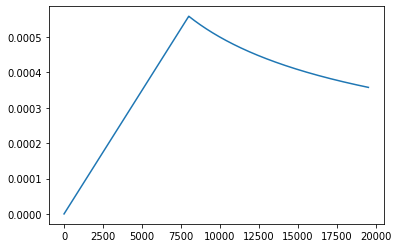

In [ ]:
import torch.optim as optim
from torch.optim.lr_scheduler import LambdaLR

def get_schedule(warmup_steps):
  def lr_schedule(step):
    return 1.0 * np.minimum(1.0, step / warmup_steps) / np.sqrt(np.maximum(step, warmup_steps))

  return lr_schedule

lr=0.05
weight_decay=0.1
warmup=8000

def training_setup():
  model = model_factory()
  criterion = nn.CrossEntropyLoss().cuda()
  optimizer = optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay, betas=(0.9, 0.999))
  schedule_func = get_schedule(warmup)
  scheduler = LambdaLR(optimizer, schedule_func)

  return model, criterion, optimizer, schedule_func, scheduler

_, _, _, schedule_func, _ = training_setup()

plt.plot([ lr * schedule_func(i) for i in range(len(train_dataset) // accumulation_steps * 25) ])

In [ ]:
import time

def save_model(model, optimizer, name='/content/drive/MyDrive/Work/Misc/lka-mini-base.tar'):
  torch.save({
              'model_state_dict': model.state_dict(),
              'optimizer_state_dict': optimizer.state_dict(),
              }, name)

def progress_bar(len, total, current):
  current_scaled = int(round(len * current / total))

  s = '[' + '=' * (current_scaled - 1)
  s += '>' if current != total else '='
  s += '-' * (len - current_scaled) + ']'

  return s

def accuracy(model_output, labels):
  model_output = model_output.argmax(dim=-1)

  return (labels == model_output).float().mean().cpu().numpy()

def train_model(model, name, train_dataset, valid_dataset, optimizer, criterion, scheduler, accumulation_steps, epochs, epoch_len=None, eps = 1e-6, skip_eval=25):
  
  best_acc = 0.0

  bnum = math.ceil(len(train_dataset) / accumulation_steps / batch_size)
  train_dataset = train_dataset.shuffle(len(train_dataset), reshuffle_each_iteration=True)

  times_repeat = epochs if epoch_len is None else math.ceil(epochs * epoch_len / bnum)
  train_dataset = train_dataset.repeat(times_repeat)
  train_datagen = iter(train_dataset)
  
  if epoch_len is not None:
    bnum = epoch_len
  
  for epoch in range(epochs):  # loop over the dataset multiple times

      #epoch start timestamp
      t = time.time()

      running_loss = 0.0
      running_reg  = 0.0
      running_acc  = 0.0

      running_momentum = 0.99

      epoch_loss = [  ]
      epoch_reg  = [  ]
      epoch_acc  = [  ]

      model.train()

      print(f'Epoch {epoch}')

      process_inputs = lambda x: torch.Tensor(x.numpy()).to(torch.int64)

      for i in range(bnum):
          # zero the parameter gradients
          optimizer.zero_grad()

          #accumulate gradients for a certain amount of steps
          for k in range(accumulation_steps):
            # get the inputs; data is a list of [inputs, labels]

            try:
              data = next(train_datagen)
            except:
              break
            inputs, labels = data['inputs'], data['targets']
            inputs, labels = process_inputs(inputs), process_inputs(labels)
            inputs, labels = inputs.cuda(), labels.cuda()

            # forward + backward + optimize
            outputs, additional_losses = model(inputs)
            loss = criterion(outputs + eps, labels)

            additional_losses = sum(additional_losses) if additional_losses else torch.Tensor([ 0.0 ]).cuda()
            ((loss + additional_losses) / accumulation_steps).backward()

            acc = accuracy(outputs, labels)

            running_loss = running_loss * running_momentum + (1 - running_momentum) * loss.item()
            running_loss_unb = running_loss / (1 - running_momentum ** (i * accumulation_steps + k + 1))

            running_acc  = running_acc  * running_momentum + (1 - running_momentum) * acc
            running_acc_unb = running_acc / (1 - running_momentum ** (i * accumulation_steps + k + 1))

            running_reg  = running_reg  * running_momentum + (1 - running_momentum) * additional_losses.item()
            running_reg_unb = running_reg / (1 - running_momentum ** (i * accumulation_steps + k + 1))

            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
            epoch_reg.append(additional_losses.item())

          optimizer.step()

          pbar = progress_bar(20, bnum, i + 1)

          print(f'\r{pbar} {i + 1}/{bnum}:', end='')
          print(f' - running_loss: {running_loss_unb:.4f} - running_reg: {running_reg_unb:.6f} - running_acc: {running_acc_unb:.4f} - lr: {scheduler.get_last_lr()[0]:.5f}', end='')

          scheduler.step()
      
      epoch_loss = np.mean(epoch_loss)
      epoch_acc  = np.mean(epoch_acc)
      epoch_reg  = np.mean(epoch_reg)
      
      print(f' - epoch_loss: {epoch_loss:.4f} - epoch_reg: {epoch_reg:.6f} - epoch_acc: {epoch_acc:.4f}', end='')

      epoch_loss, epoch_acc, epoch_reg = [], [], []

      
      if epoch >= skip_eval:
        model.eval()
        valid_dataset.repeat()

        with torch.no_grad():
          for i, data in enumerate(iter(valid_dataset)):
            inputs, labels = data['inputs'], data['targets']
            inputs, labels = process_inputs(inputs), process_inputs(labels)
            inputs, labels = inputs.cuda(), labels.cuda()

            outputs, aux_losses = model(inputs)
            loss = criterion(outputs, labels)
            acc = accuracy(outputs, labels)
            aux_losses = sum(aux_losses) if aux_losses else torch.Tensor([ 0.0 ]).cuda()

            epoch_loss.append(loss.item())
            epoch_acc.append(acc)
            epoch_reg.append(aux_losses.item())

        epoch_loss, epoch_acc, epoch_reg = np.mean(epoch_loss), np.mean(epoch_acc), np.mean(epoch_reg)

        if epoch_acc > best_acc:
          best_acc = epoch_acc
          save_model(model, optimizer, name)
      
      else:
        epoch_loss, epoch_acc, epoch_reg = 0.0, 0.0, 0.0

      #epoch computing time
      t = time.time() - t

      print(f' - valid_loss: {epoch_loss:.4f} - valid_reg: {epoch_reg:.6f} - valid_acc: {epoch_acc:.4f} - epoch_time: {t:.4f} s')
 
  checkpoint = torch.load(name)
  return checkpoint

In [ ]:
def test(model, criterion, test_dataset):
  epoch_loss, epoch_acc, epoch_reg = [], [], []

  model.eval()
  test_dataset.repeat()

  process_inputs = lambda x: torch.Tensor(x.numpy()).to(torch.int64)

  t = time.time()

  with torch.no_grad():
    for i, data in enumerate(iter(test_dataset)):
      inputs, labels = data['inputs'], data['targets']
      inputs, labels = process_inputs(inputs), process_inputs(labels)
      inputs, labels = inputs.cuda(), labels.cuda()

      outputs, aux_losses = model(inputs)
      loss = criterion(outputs, labels)
      acc = accuracy(outputs, labels)
      aux_losses = sum(aux_losses) if aux_losses else torch.Tensor([ 0.0 ]).cuda()

      epoch_loss.append(loss.item())
      epoch_acc.append(acc)
      epoch_reg.append(aux_losses.item())

  t = time.time() - t

  epoch_loss, epoch_acc, epoch_reg = np.mean(epoch_loss), np.mean(epoch_acc), np.mean(epoch_reg)

  print(f' - test_loss: {epoch_loss:.4f} - test_reg: {epoch_reg:.6f} - test_acc: {epoch_acc:.4f} - test_time: {t:.4f} s')
  return epoch_loss, epoch_reg, epoch_acc

In [ ]:
test_accuracy = [  ]

for i in range(5): ####!!!!!!!!!!!!!!
  path = 'model_to_test_' + str(i) + '.b'

  model, criterion, optimizer, schedule_func, scheduler = training_setup()

  checkpoint = train_model(model, path, train_dataset, valid_dataset, optimizer, criterion, scheduler, accumulation_steps, 100, 200, skip_eval=0)
  model.load_state_dict(checkpoint['model_state_dict'])
  
  _, _, acc = test(model, criterion, test_dataset)
  test_accuracy.append(acc)

test_accuracy = np.mean(test_accuracy)

print(f'\nTotal accuracy: {test_accuracy:.4f}')

Original model 10832898 params, new model 10043394 params, ratio 0.927
Epoch 0
[====================] 200/200: - running_loss: 0.6925 - running_reg: 0.000000 - running_acc: 0.5140 - lr: 0.00001 - epoch_loss: 0.6971 - epoch_reg: 0.000000 - epoch_acc: 0.5139 - valid_loss: 0.6913 - valid_reg: 0.000000 - valid_acc: 0.5286 - epoch_time: 213.4600 s
Epoch 1
[====================] 200/200: - running_loss: 0.6968 - running_reg: 0.000000 - running_acc: 0.5036 - lr: 0.00003 - epoch_loss: 0.6937 - epoch_reg: 0.000000 - epoch_acc: 0.5169 - valid_loss: 0.6918 - valid_reg: 0.000000 - valid_acc: 0.5182 - epoch_time: 202.4284 s
Epoch 2
[====================] 200/200: - running_loss: 0.6883 - running_reg: 0.000000 - running_acc: 0.5625 - lr: 0.00004 - epoch_loss: 0.6915 - epoch_reg: 0.000000 - epoch_acc: 0.5427 - valid_loss: 0.7154 - valid_reg: 0.000000 - valid_acc: 0.5140 - epoch_time: 202.4051 s
Epoch 3
[====================] 200/200: - running_loss: 0.6835 - running_reg: 0.000000 - running_acc: 0.559

KeyboardInterrupt: ignored

In [ ]:
Simple double norm: 6680, 6657, 6658, 6637, 6655

In [ ]:
Simple seq norm: 6654, 6675, 6651, 6669, 6657

In [ ]:
Simple nonorm: 6652, 6668, 6646, 6645, 6648

In [ ]:
beta2 0.98 simple: 6634, 

In [ ]:
3 x AOGLU l=0.0: 0.6610, 0.6571, 0.6601, 0.6568, 0.6622

In [ ]:
FFN l=0.005: 0.6585, 0.6530, 0.6589, 0.6601, 0.6594

In [ ]:
FFN noorth: 0.6582, 0.6456, 0.6605, 0.6591, 0.5521, | 0.6580, 0.6530

In [ ]:
2 x OGLU l=0.1: 0.6596, 0.6591, 0.6578, 0.6635, 0.6601

In [ ]:
2 x OGLU l=0.01:0.6639, 0.6594, 0.6591, 0.6586, 0.6625

In [ ]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output[0].detach()
    return hook

process_inputs = lambda x: torch.Tensor(x.numpy()).to(torch.int64)

list(model.blocks[-1].attention.lka.modules())[0][0].register_forward_hook(get_activation('1'))
#list(model.blocks[-1].attention.lka.modules())[0][1].register_forward_hook(get_activation('2'))

In [ ]:
model(process_inputs(next(iter(train_dataset))['inputs']).cuda())
activation

{'1': tensor([[[[0.4846, 0.6129, 1.0817,  ..., 0.8458, 0.8182, 0.6113],
           [0.6741, 1.0226, 0.9306,  ..., 0.6382, 0.4864, 0.4956],
           [0.7144, 0.7925, 0.9776,  ..., 0.8392, 0.8342, 0.6923],
           ...,
           [0.6351, 0.4956, 0.8323,  ..., 1.1306, 0.8587, 0.7959],
           [0.6259, 1.0617, 0.9905,  ..., 0.7249, 0.8088, 0.8153],
           [0.7734, 0.8578, 0.5455,  ..., 0.5648, 0.7239, 0.6971]],
 
          [[1.1219, 0.8068, 0.7288,  ..., 0.5271, 1.1042, 0.6128],
           [0.8955, 0.9000, 1.3224,  ..., 0.5096, 0.5674, 1.1289],
           [0.7283, 0.8557, 0.4822,  ..., 0.8176, 0.3683, 0.6196],
           ...,
           [0.6962, 0.6160, 0.4413,  ..., 1.0298, 0.8417, 0.8641],
           [1.0189, 0.9670, 0.5587,  ..., 0.9078, 0.7291, 0.7901],
           [0.6431, 0.5184, 0.5831,  ..., 0.6299, 0.6459, 0.6050]],
 
          [[0.6520, 0.8644, 0.8144,  ..., 0.5583, 0.4932, 0.5764],
           [0.3789, 0.7886, 0.5084,  ..., 0.7604, 0.5583, 0.4504],
           [0.8306,

In [ ]:
model, criterion, _, _, _ = training_setup()
tmp = next(iter(train_dataset))
outputs, aux_losses = model(process_inputs(tmp['inputs']).cuda())

aux_losses = sum(aux_losses)
(criterion(outputs, process_inputs(tmp['targets']).cuda()) + aux_losses).backward()

Original model 3464194 params, new model 3663874 params, ratio 1.06


In [ ]:
list(model.blocks[-1].attention.lka.modules())[0][0].output_bias

Parameter containing:
tensor([[[[-2.6187e-03, -5.7948e-04, -3.2907e-04,  6.2941e-04, -7.1119e-04,
           -4.3961e-04,  2.6415e-03,  9.3061e-04,  2.9606e-03, -2.6636e-04,
           -1.7387e-03,  1.6021e-03,  9.3624e-04,  1.1273e-03, -3.3982e-04,
           -4.0739e-04, -2.0149e-03,  9.0991e-04, -1.0498e-03, -2.7959e-03,
            2.5112e-04, -9.3633e-04,  6.2485e-04, -1.3612e-03, -2.9829e-04,
           -2.0080e-04,  7.8189e-04,  7.8589e-04, -5.3443e-03, -3.7092e-03,
           -2.3028e-04,  3.1588e-03, -2.2930e-04,  3.9736e-03,  4.0218e-04,
            1.0651e-03,  7.7839e-03,  1.8654e-04, -3.1373e-03,  1.4372e-03,
            4.1014e-03, -1.0334e-03, -8.9334e-04, -2.3530e-04, -1.0687e-03,
           -2.1504e-03, -1.1092e-03,  1.7172e-05,  1.2050e-03, -1.5283e-03,
            1.4103e-04, -2.1979e-03, -5.9292e-05,  2.5531e-03, -4.6291e-03,
            8.9993e-04,  5.3557e-05, -1.8944e-03,  6.1842e-04, -3.0434e-03,
           -2.6042e-03, -2.7910e-03,  1.9914e-03,  3.3585e-03]],



In [ ]:
import torch.nn as nn
import math

LAMBDA = 0.1

class TEmbedding(nn.Module):
  def __init__(self, num_embeddings, hidden_dim, seq_length=1024, padding_idx=0):
    super(TEmbedding, self).__init__()
    
    self.num_embeddings = num_embeddings
    self.hidden_dim=hidden_dim
    self.seq_length = seq_length
    self.padding_idx = padding_idx

    self.embedding = nn.Embedding(num_embeddings, hidden_dim, padding_idx)
    self.pos_embeds  = nn.Parameter(torch.zeros(1, self.seq_length, self.hidden_dim))

    self.cls = nn.Parameter(torch.zeros(1, 1, self.hidden_dim)) #!!!!!!! INIT WITH ANOTHER VALUE IF REQUIRED

  def forward(self, input):
    batch_size, seq_len = input.shape
    
    embed = self.embedding(input)
    embed = embed + self.pos_embeds
    embed = torch.cat([ self.cls.expand(batch_size, 1, -1), embed ], axis=1)

    return embed

class TAttention(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, num_heads, dropout_rate):
    super(TAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.qkv_dim   =qkv_dim
    self.num_heads =num_heads
    
    assert not qkv_dim % num_heads
    
    self.head_dim = qkv_dim // num_heads

    self.q = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.k = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.v = nn.Linear(self.hidden_dim, self.qkv_dim)

    self.lin = nn.Linear(self.qkv_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_rate)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)
    q = torch.mul(q, 1. / torch.sqrt(torch.tensor(self.qkv_dim)))

    qk = torch.matmul(q, k.transpose(-1, -2))
    qk = nn.Softmax(dim=-1)(qk)

    def assertion_function(tsr):
      tsr = torch.sum(tsr, axis=-1)
      tsr = tsr - torch.ones_like(tsr)
      return torch.max(torch.abs(tsr)) < 1e-5

    assert assertion_function(qk)

    qk = self.dropout(qk) #Like in TF implementation; could be done before Softmax by random -inf addition

    out = torch.matmul(qk, v)
    out = out.permute(0, 2, 1, 3)

    new_shape = out.shape[:-2] + (self.qkv_dim,)

    out = out.reshape(* new_shape)

    out = self.lin(out)

    return out

class HWLinear(nn.Module):
  def __init__(self, num_heads, input_dim, output_dim, use_bias):
    super(HWLinear, self).__init__()
    
    self.use_bias = use_bias
    if use_bias:
      self.bias   = nn.Parameter(torch.zeros( (1, num_heads, 1, output_dim)))

    self.weight = nn.Parameter(torch.empty( (num_heads, input_dim, output_dim)))

    def he_init(m):
      s =  np.sqrt( 2. / input_dim )
      m.data.normal_(0, s)

    he_init(self.weight)

  def forward(self, x):
    x = torch.matmul(x, self.weight)
    if self.use_bias:
      x += self.bias
    return x

class Lambda(nn.Module):
  def __init__(self, lambda_, objects=None):
      super(Lambda, self).__init__()
      self.lambda_ = lambda_
      self.objects = objects

  def forward(self, x):
    if self.objects is not None:
      return self.lambda_(self.objects, x)
    return self.lambda_(x)

class LKAAttention(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, num_heads, dropout_rate):
    super(LKAAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.qkv_dim   = qkv_dim
    self.num_heads =num_heads

    assert not qkv_dim % num_heads
    
    self.head_dim = qkv_dim // num_heads
    
    self.q = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.k = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.v = nn.Linear(self.hidden_dim, self.qkv_dim)

    #self.lka = nn.Sequential(
    #  nn.Linear(self.head_dim, self.head_dim), nn.GELU(),
    #  nn.Linear(self.head_dim, self.head_dim), nn.Softplus(beta=2.5),
    #)

    #256, 4, 16, 1024
    #256, 64, 1, 1024
    class AMGOLU(nn.Module):
      def __init__(self, num_heads, qkv_dim, gate_rank, dropout_rate, gate_nonlinearity, kernel_nonlinearity, use_bias=False):
        super(AMGOLU, self).__init__()

        self.head_dim = qkv_dim // num_heads
        self.num_heads= num_heads
        
        self.orth_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)
        self.orth_weight.weight = nn.Parameter(torch.stack([ nn.init.orthogonal_(torch.empty((self.head_dim, self.head_dim))) for _ in range(num_heads) ], dim=0))

        self.gate_weight_a = HWLinear(num_heads, self.head_dim, gate_rank, use_bias)
        self.gate_weight_b = HWLinear(num_heads, gate_rank, self.head_dim, use_bias)

        self.kernel_nonlinearity = kernel_nonlinearity
        self.gate_nonlinearity   = gate_nonlinearity

        self.dropout = nn.Dropout(dropout_rate)

      def forward(self, x):
        x, losses = x
        x = self.dropout(x)

        forward_info = self.orth_weight(x)
        forward_info = self.kernel_nonlinearity(forward_info)

        gate_info = self.gate_weight_a(x)
        gate_info = self.gate_weight_b(gate_info)
        gate_info = self.gate_nonlinearity(gate_info)

        x = forward_info * gate_info
        
        loss = torch.eye(self.head_dim, device=self.orth_weight.weight.device).unsqueeze(0).expand(self.num_heads, -1, -1)
        loss = nn.MSELoss()(torch.matmul(self.orth_weight.weight, self.orth_weight.weight.transpose(-1, -2)), loss)
        loss *= LAMBDA

        losses.append(loss)

        return x, losses

    class GatedOrthoKernel(nn.Module):
      def __init__(self, num_heads, qkv_dim, dropout_rate=0.1, gate_nonlinearity=nn.Sigmoid(), kernel_nonlinearity=nn.Identity(), use_bias=False):
        super(GatedOrthoKernel, self).__init__()

        self.head_dim = qkv_dim // num_heads
        self.num_heads = num_heads

        self.orth_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)
        self.orth_weight.weight = nn.Parameter(torch.stack([ nn.init.orthogonal_(torch.empty((self.head_dim, self.head_dim))) for _ in range(num_heads) ], dim=0))
        self.gate_weight = HWLinear(num_heads, self.head_dim, self.head_dim, use_bias)

        self.kernel_nonlinearity = kernel_nonlinearity
        self.gate_nonlinearity   = gate_nonlinearity

        self.dropout = nn.Dropout(dropout_rate)

      def forward(self, x):
        x, losses = x
        x = self.dropout(x)

        x = self.kernel_nonlinearity(self.orth_weight(x)) * self.gate_nonlinearity(self.gate_weight(x))
        
        loss = torch.eye(self.head_dim, device=self.orth_weight.weight.device).unsqueeze(0).expand(self.num_heads, -1, -1)
        loss = nn.MSELoss()(torch.matmul(self.orth_weight.weight, self.orth_weight.weight.transpose(-1, -2)), loss)
        loss *= LAMBDA

        losses.append(loss)

        return x, losses


    class HeadWiseFF(nn.Module):
      def __init__(self, num_heads, qkv_dim, dropout_rate, nonlinearity=nn.Identity(), use_bias=False, residual=False):
        super(HeadWiseFF, self).__init__()
        
        head_dim = qkv_dim // num_heads

        self.bias   = nn.Parameter(torch.empty( (1, num_heads, 1, head_dim)))
        self.dropout= nn.Dropout(dropout_rate)
        self.use_bias = use_bias

        self.weight = nn.Parameter(torch.empty( (num_heads, head_dim, head_dim)))
        nn.init.kaiming_uniform_(self.weight, a=math.sqrt(5))

        #Orthogonal initialization
        #Workaround with torch.stack, since Torch initializes a tensor as orthgonal by flattening its trailing dims and QR-factorizing the resulting 2d
        
        #self.weight = torch.stack([ nn.init.orthogonal_(torch.empty((head_dim, head_dim))) for _ in range(num_heads) ], dim=0)
        #self.weight = nn.Parameter(self.weight)

        bound = 1 / math.sqrt(head_dim)
        nn.init.uniform_(self.bias, -bound, bound)

        self.nonlinearity = nonlinearity
        self.residual= residual

      def forward(self, x):
        
        x, losses = x

        bs, hd, seq, hdim = x.shape
        y = self.dropout(x)
        y = torch.matmul(y, self.weight) #BS, HD, SEQ, HDIM
        if self.use_bias:
          y += self.bias
        y = self.nonlinearity(y)

        #loss = torch.eye(hdim, device=self.weight.device).unsqueeze(0).expand(* self.weight.shape)
        #loss = nn.MSELoss()(torch.matmul(self.weight, self.weight.transpose(-1, -2)), loss)
        #loss *= LAMBDA

        #losses.append(loss)

        if self.residual:
          return x + y, losses
        return y, losses

    self.lka = nn.Sequential(
        
        #AMGOLU(self.num_heads, self.qkv_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        #AMGOLU(self.num_heads, self.qkv_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        #AMGOLU(self.num_heads, self.qkv_dim, self.head_dim // 4, dropout_rate, nn.Sigmoid(), nn.Softplus(), False),
        
        #HeadWiseFF(self.num_heads, self.qkv_dim, dropout_rate, nn.Softplus(), use_bias=False),
        
        GatedOrthoKernel(self.num_heads, self.qkv_dim, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        GatedOrthoKernel(self.num_heads, self.qkv_dim, dropout_rate, nn.Sigmoid(), nn.Identity(), False),
        GatedOrthoKernel(self.num_heads, self.qkv_dim, dropout_rate, nn.Sigmoid(), nn.Softplus(), False)

        #Lambda(lambda o, x: (o['act'](x[0]), x[1]), { 'act' : nn.Identity() })
        
    )

    self.lin = nn.Linear(self.qkv_dim, self.hidden_dim)

    self.dropout = nn.Dropout(dropout_rate)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v)
    #BS x HEADS x SEQ x HEAD_DIM
    
    q, _ = self.lka((q, losses))
    k, _ = self.lka((k, losses)) #Use this for var kernel

    q = q / math.sqrt(self.head_dim)
    k = k / math.sqrt(self.head_dim)

    numerator = torch.matmul(k.unsqueeze(-1), v.unsqueeze(-2))
    numerator = numerator.sum(axis=2)
    numerator = torch.matmul(q, numerator)
    
    denominator = k.sum(axis=2).unsqueeze(-1)
    denominator = q.matmul(denominator)

    out = numerator / denominator
    out = out.permute(0, 2, 1, 3)
    
    #TODO: INSERT DROPOUT
    
    new_shape = out.shape[:-2] + (self.qkv_dim,)
    out = out.reshape(* new_shape)

    out = self.lin(out)

    return out

class SimpleAttention(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, num_heads, dropout_rate):
    super(SimpleAttention, self).__init__()
    self.hidden_dim=hidden_dim
    self.qkv_dim   =qkv_dim
    self.num_heads =num_heads

    assert not qkv_dim % num_heads
    
    self.head_dim =hidden_dim // num_heads
    
    self.q = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.k = nn.Linear(self.hidden_dim, self.qkv_dim)
    self.v = nn.Linear(self.hidden_dim, self.qkv_dim)

    self.dropout = nn.Dropout(dropout_rate)
    #self.lin = nn.Linear(self.qkv_dim, self.hidden_dim)

  def split_heads(self, x):
    new_shape = x.shape[:-1] + (self.num_heads, self.head_dim)
    x = x.view(* new_shape)
    return x.permute(0, 2, 1, 3)

  def forward(self, x, losses=[]):
    q = self.q(x)
    k = self.k(x)
    v = self.v(x)

    q, k, v = self.split_heads(q), self.split_heads(k), self.split_heads(v) #BS x HEADS x SEQ x HEAD_DIM

    self.last_q = q
    self.last_k = k
    self.last_v = v

    _, _, seq_len, _ = q.shape

    self.last_qk = torch.matmul(q, k.transpose(-1, -2))

    kv = torch.matmul(k.transpose(-1, -2), v)
    kv *= 1 / math.sqrt(seq_len)
    kv = self.dropout(kv)

    out = torch.matmul(q, kv)
    #out *= 1 / math.sqrt(self.qkv_dim)
    out = out.permute(0, 2, 1, 3)
    
    new_shape = out.shape[:-2] + (self.qkv_dim,)
    out = out.reshape(* new_shape)

    #out = self.lin(out)

    return out

class FtAttention(nn.Module):
  def __init__(self, *args, **kwargs):
    super(FtAttention, self).__init__()

  def forward(self, x, losses=[]):
    return torch.fft.fft(torch.fft.fft(x, dim=-1), dim=-2).real

class TBlock(nn.Module):
  def __init__(self, hidden_dim, qkv_dim, mlp_dim, num_heads, dropout_rate):
    super(TBlock, self).__init__()

    self.hidden_dim = hidden_dim
    self.qkv_dim  = qkv_dim
    self.mlp_dim  = mlp_dim

    self.layernorm_input = nn.LayerNorm(hidden_dim, eps=1e-6)
    self.layernorm_inter = nn.LayerNorm(hidden_dim, eps=1e-6)

    self.attention = TAttention(hidden_dim, qkv_dim, num_heads, dropout_rate)

    self.ffn       = nn.Sequential(
        nn.Linear(hidden_dim, mlp_dim), nn.GELU(), nn.Dropout(dropout_rate),
        nn.Linear(mlp_dim, hidden_dim), nn.Dropout(dropout_rate),
    )


  def forward(self, input, losses=[]):
    x = self.layernorm_input(input)
    x = self.attention(x, losses)

    x = input + x

    y = self.layernorm_inter(x)
    x = self.ffn(y) + x

    return x

class TClassifier(nn.Module):
  def __init__(self, classes, hidden_dim, inter_dim, dropout_rate):
    super(TClassifier, self).__init__()

    self.layernorm = nn.LayerNorm(hidden_dim, eps=1e-6)
    self.dropout   = nn.Dropout(dropout_rate)

    self.ffn       = nn.Sequential(
        nn.Linear(hidden_dim, inter_dim), nn.GELU(),
    )
    self.output    = nn.Linear(inter_dim, classes)

  def forward(self, x):
    x = self.layernorm(x)
    x = x[:, 0, :]
    x = self.dropout(x)

    x = self.ffn(x)
    logits = self.output(x)

    return logits

class IEmbedding(nn.Module):
  def __init__(self, resolution, hidden_dim):
    super(IEmbedding, self).__init__()
    
    self.hidden_dim=hidden_dim
    self.seq_length = resolution ** 2
    
    self.embedding = nn.Conv2d(1, hidden_dim, 1)
    self.pos_embeds  = nn.Parameter(torch.zeros(1, self.seq_length, self.hidden_dim))

    self.cls = nn.Parameter(torch.zeros(1, 1, self.hidden_dim)) #!!!!!!! INIT WITH ANOTHER VALUE IF REQUIRED

  def forward(self, input):
    #Expecting the tf-style Torch tensor = BS x H x W x C
    input = input.transpose(1, 3)
    embed = self.embedding(input)
    
    batch_size, channels, height, width = embed.shape
    
    embed = embed.view(batch_size, self.hidden_dim, -1).transpose(-1, -2)
    embed = embed + self.pos_embeds
    embed = torch.cat([ self.cls.expand(batch_size, 1, -1), embed ], axis=1)

    return embed

class Transformer(nn.Module):
  def __init__(self, classes, num_embeddings, seq_len, hidden_dim, qkv_dim, mlp_dim, num_heads, num_blocks, output_mlp_units, internal_dropout_rate=0.1, output_dropout_rate=0.0):
    super(Transformer, self).__init__()
    
    self.embed_layer = TEmbedding(num_embeddings, hidden_dim, seq_len)
    self.blocks      = nn.ModuleList([ TBlock(hidden_dim, qkv_dim, mlp_dim, num_heads, internal_dropout_rate) for _ in range(num_blocks) ])
    self.classifier  = TClassifier(classes, hidden_dim, output_mlp_units, output_dropout_rate)

  def forward(self, pixel_values):
    additional_losses = []

    x = self.embed_layer(pixel_values)
    
    for block in self.blocks:
      x = block(x, additional_losses)
    
    x = self.classifier(x)

    return x, additional_losses

In [ ]:
process_inputs = lambda x: torch.Tensor(x.numpy()).to(torch.int64)
model, criterion, _, _, _ = training_setup()

model.load_state_dict(torch.load('/content/drive/MyDrive/simple.b')['model_state_dict'])

Original model 4514818 params, new model 4251650 params, ratio 0.942


<All keys matched successfully>

In [ ]:
test(model, criterion, test_dataset)

 - test_loss: 0.6150 - test_reg: 0.000000 - test_acc: 0.6658 - test_time: 173.2152 s


(0.6150012535715104, 0.0, 0.6658)

In [ ]:
tmp = process_inputs(next(iter(valid_dataset))['inputs']).cuda()

In [ ]:
model(tmp)

(tensor([[-0.0716,  0.0235],
         [-0.8326,  0.8034],
         [-0.4854,  0.4479],
         [ 0.2284, -0.2567],
         [-0.9056,  0.8776],
         [-0.6874,  0.6532],
         [ 0.1294, -0.1662],
         [-0.7306,  0.6965]], device='cuda:0', grad_fn=<AddmmBackward0>), [])

In [ ]:
model.blocks[-1].attention.last_qk.shape

torch.Size([8, 4, 4001, 4001])

In [ ]:
np.max(img)

TypeError: ignored

In [ ]:
model.blocks[-1].attention.last_qk.shape

torch.Size([8, 4, 4001, 4001])

In [ ]:
import torch.nn.functional as F

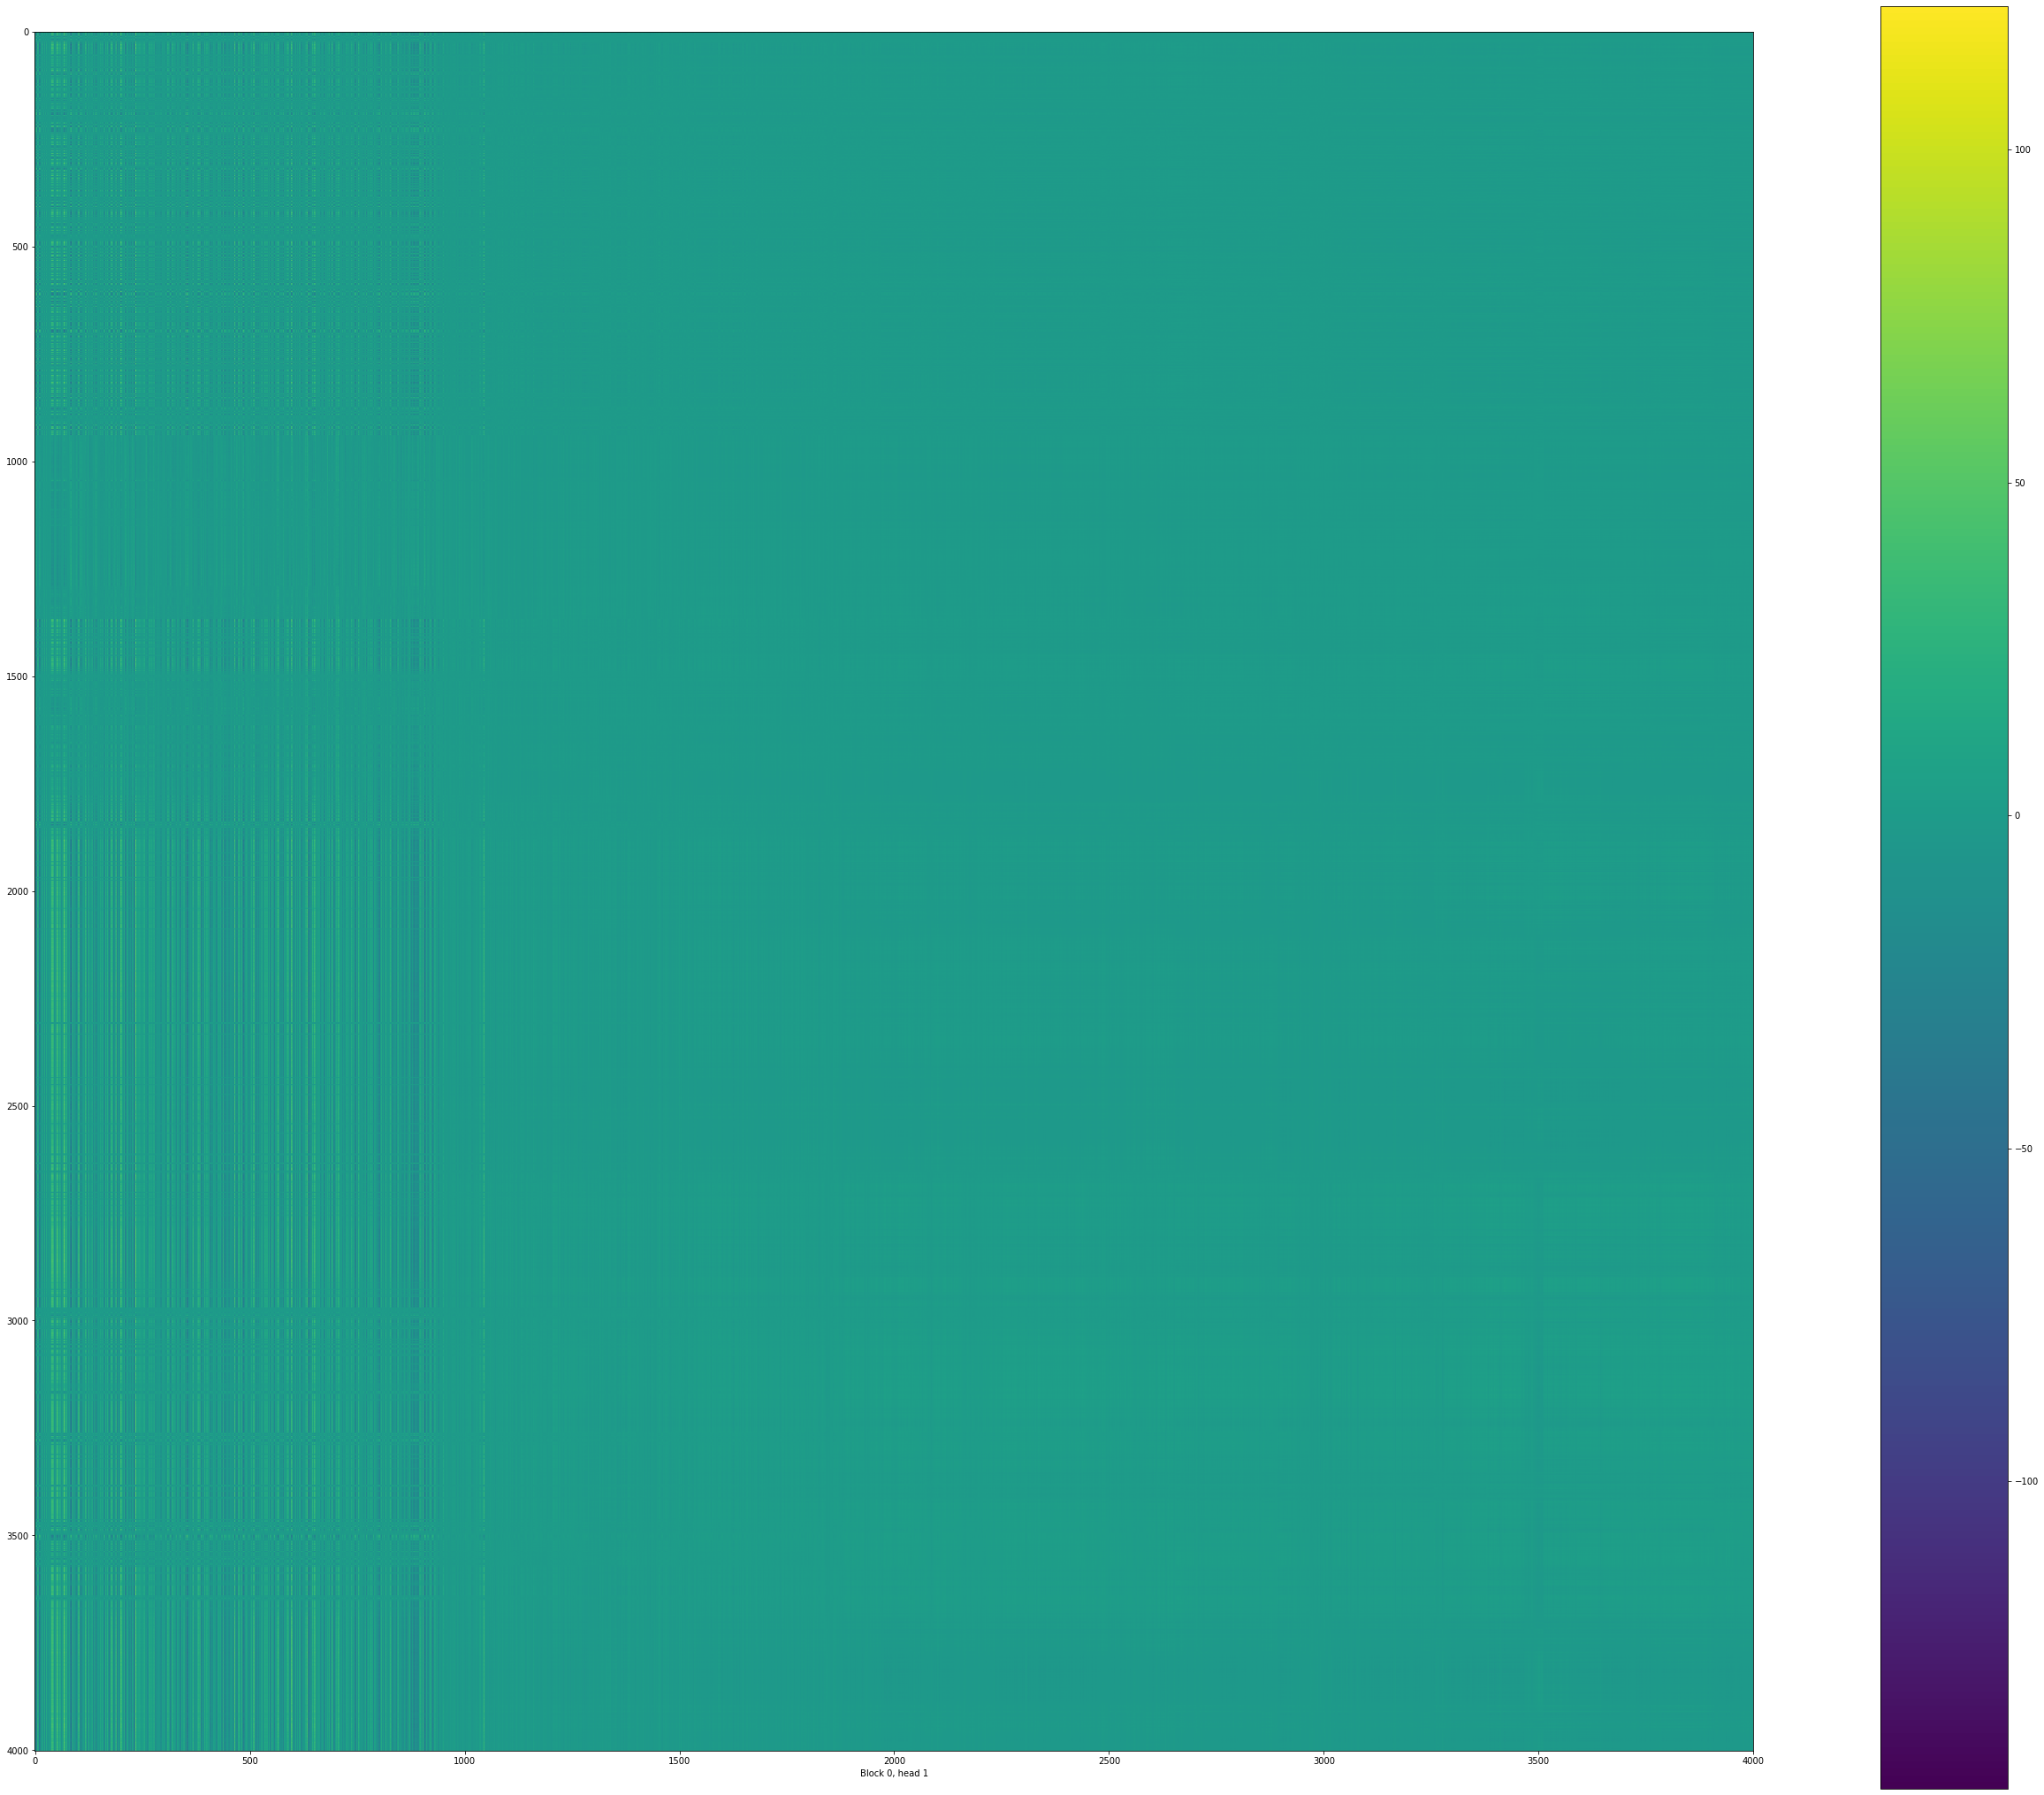

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

sample = 0
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(40, 40))#plt.subplots(figsize=(20, 20), ncols=4, nrows=len(model.blocks))
ax = np.array(ax)
for i, axis in enumerate(ax.flat):
  block = i // 4
  head  = i % 4

  block = 0
  head = 1

  img = model.blocks[block].attention.last_qk[sample, head].cpu().detach()
  #img = F.max_pool2d(input=img.unsqueeze(0), kernel_size=10).squeeze(0)

  im = axis.imshow(img)

  axis.set_xlabel(f'Block {block}, head {head}')

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(im, cax=cbar_ax)

plt.show()

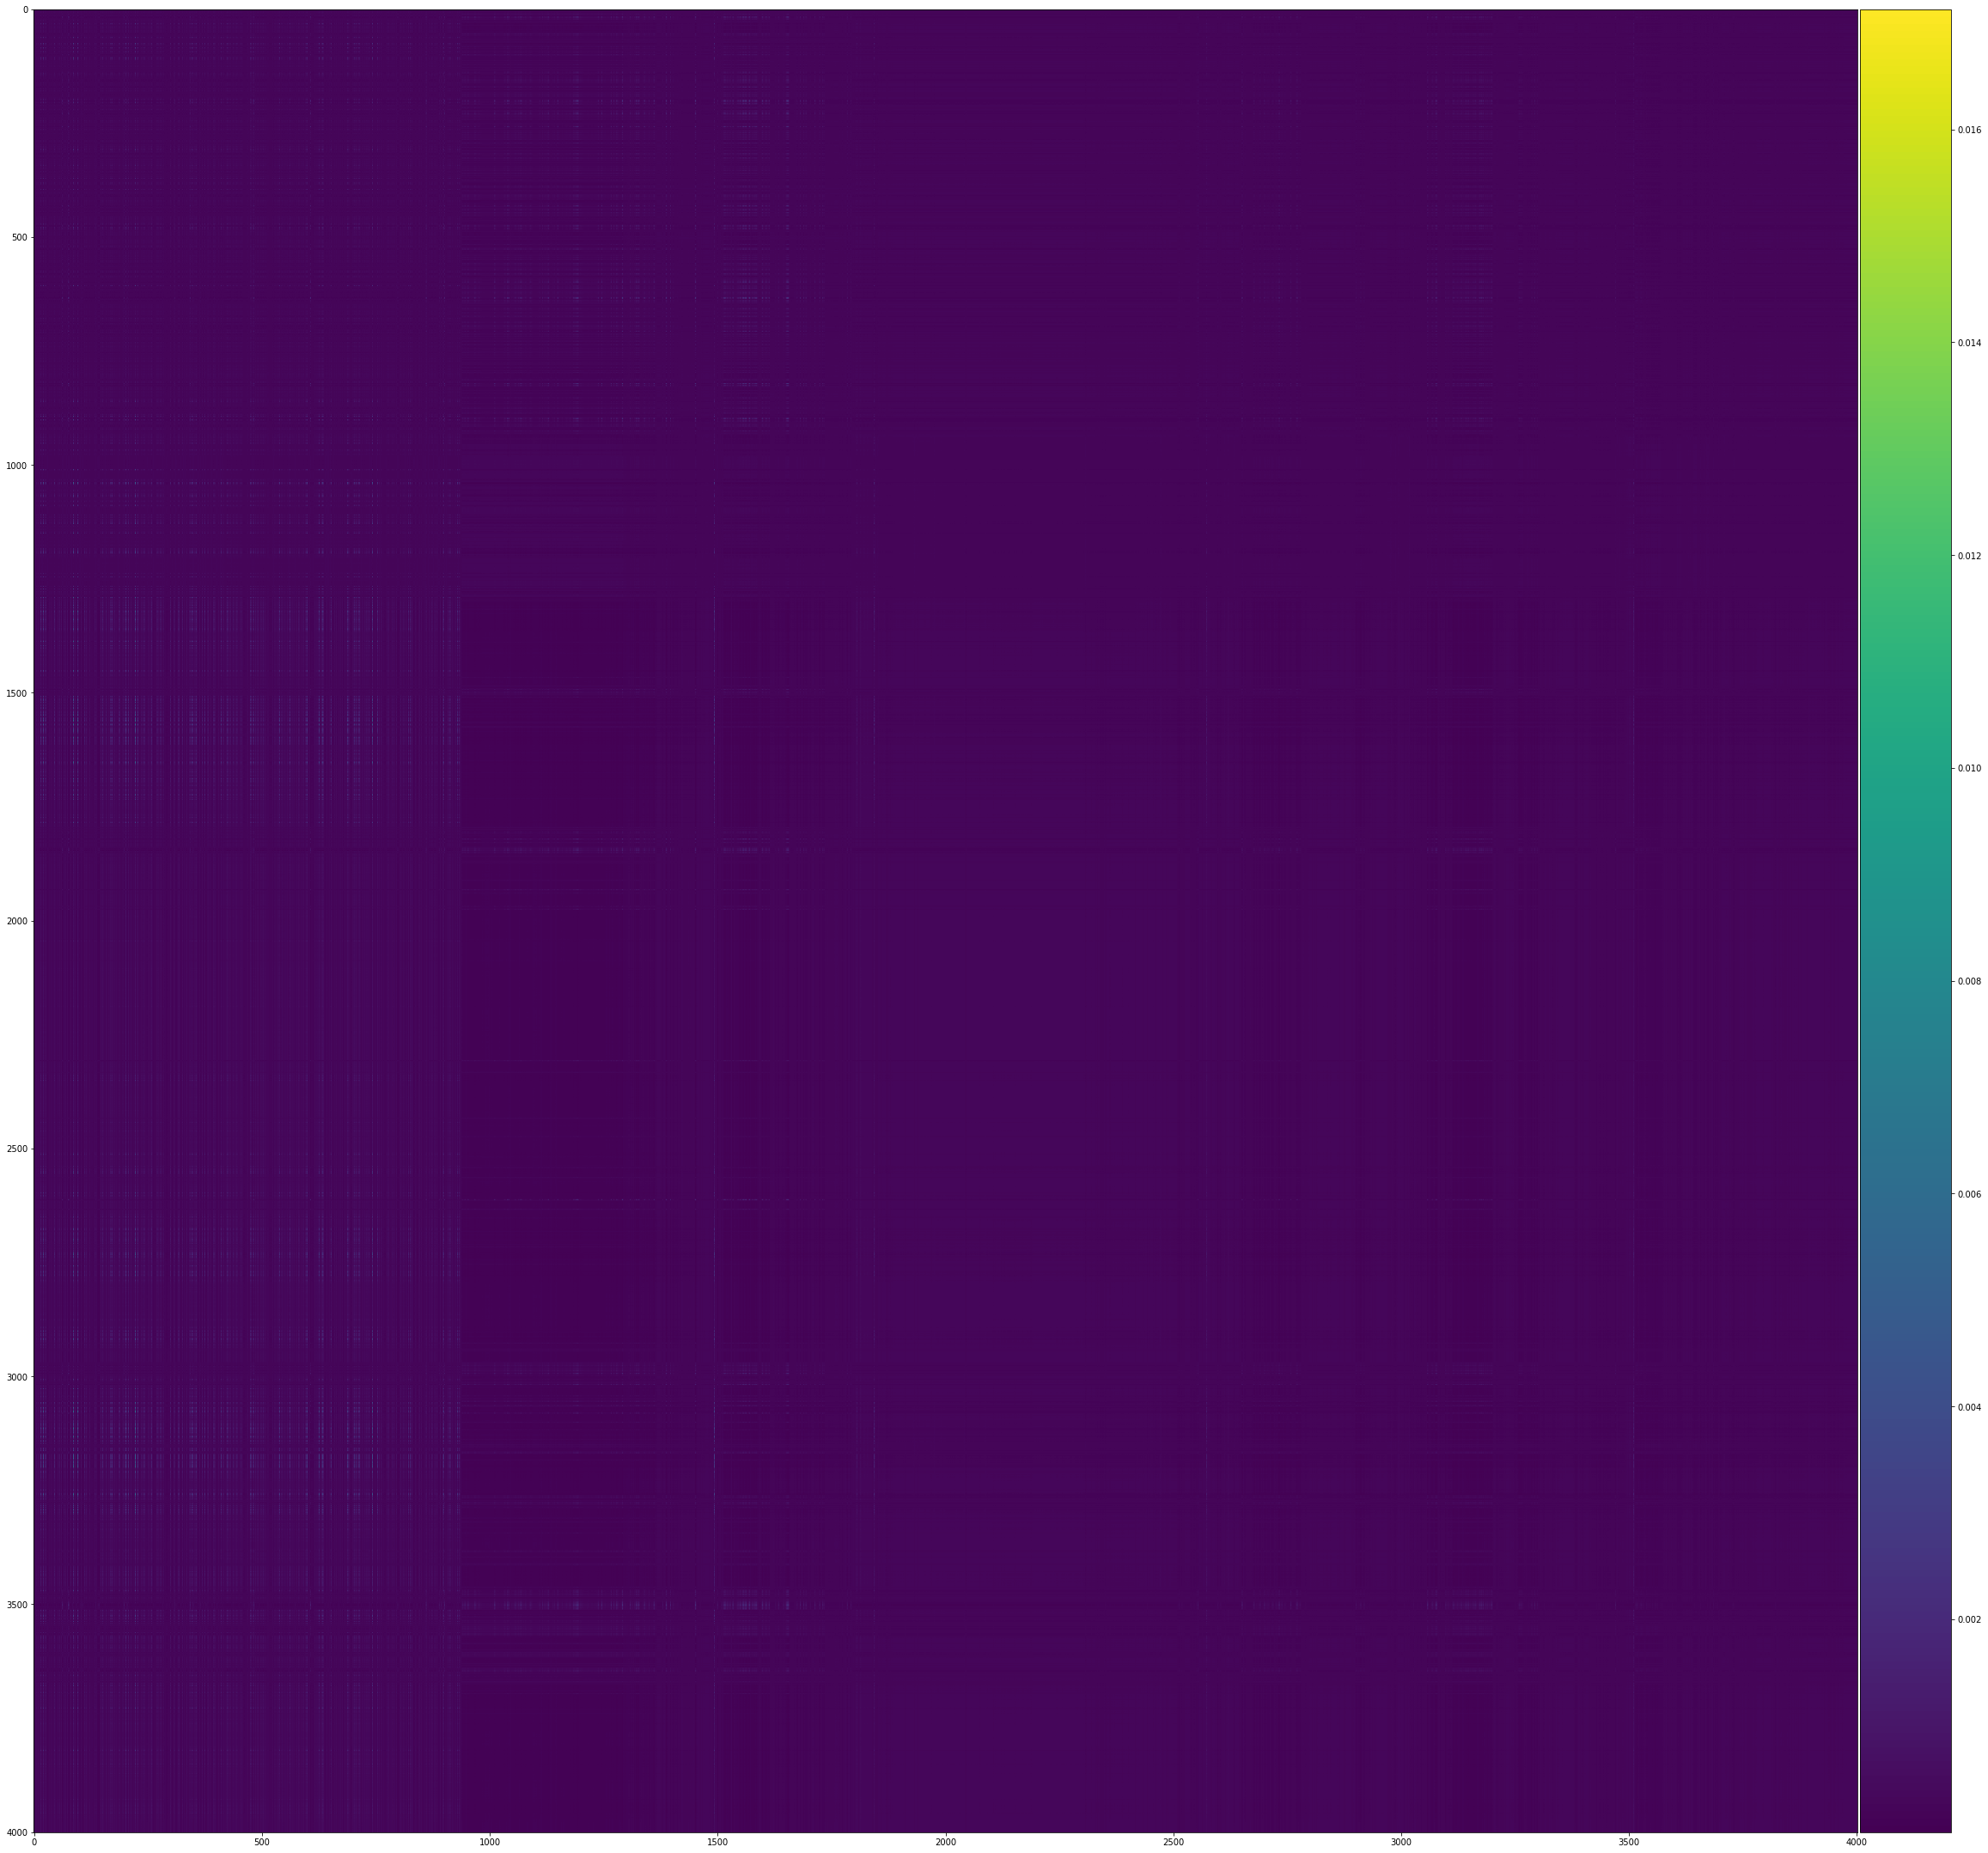

In [ ]:
img = nn.functional.softmax(img, -1)

plt.figure(figsize=(40,40))
ax = plt.subplot()
im = ax.imshow(img)

divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)

plt.colorbar(im, cax=cax)

plt.show()

In [ ]:
img.argmax(dim=-1)

tensor([ 634, 1292, 3194,  ...,  634,  634,  634])

In [ ]:
img.max(dim=-1)

torch.return_types.max(values=tensor([ 3.0878, 91.3975,  1.2315,  ...,  2.1402,  2.0813,  1.9522]), indices=tensor([ 634, 1292, 3194,  ...,  634,  634,  634]))